In [2]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.curdir, '..')))
print(sys.path)
import trimesh
import k3d
import numpy as np
from util.visualization.utils_mesh import get_watertight_mesh_for_latent
import torch
import numpy as np
import k3d
import trimesh
from tqdm import tqdm
from util.misc import get_model
from models.model_factory import ModelFactory
from models.net_w_partials import NetWithPartials
from util.checkpointing import get_model_path_via_wandb_id_from_fs
from util.const import MODELS_PARENT_DIR
from models.wire import ConditionalWIRE

import matplotlib.pyplot as plt
%matplotlib inline

['/system/apps/userenv/volkmann/ginn_fenicsx_env/lib/python312.zip', '/system/apps/userenv/volkmann/ginn_fenicsx_env/lib/python3.12', '/system/apps/userenv/volkmann/ginn_fenicsx_env/lib/python3.12/lib-dynload', '', '/system/apps/userenv/volkmann/ginn_fenicsx_env/lib/python3.12/site-packages', '/system/user/volkmann/objgen_main/objgen']


In [3]:
## Parameters
device = 'cuda:0'
cfg = {
    # 'model': {
    #     'layers': [128, 128, 128],
    #     'w0': 1.0,
    #     'w0_initial': 18,
    #     'wire_scale': 6,
    #     'model': 'cond_wire',
    # },
    'nx': 3,
    'ny': 1,
    'nz': 2,
    'level_set': 0.5,
    'envelope_sample_from': 'exterior',
    'n_points_domain': 2048,  # used for eikonal loss
    'n_points_envelope': 16384,
    'n_points_interfaces': 4096,
    'n_points_normals': 4096,
    
    'mc_resolution': 128,
    'exclude_surface_points_close_to_interface_cutoff': 0.025,  # 0.0 means no interface points are excluded
    'bounds': torch.from_numpy(np.load('../GINN/simJEB/data/bounds.npy')).float().to(device),
    'device': device,
    'ginn_bsize': 2,
    'surf_pts_recompute_every_n_epochs': 1,
    'n_points_surface': 8192, # 32768  ## nof points for initializing the flow to surface
    'surf_pts_lr': 0.01, ## learning rate for non-Newton optimizer
    'surf_pts_n_iter': 20, # iterations of surface flow
    'surf_pts_prec_eps': 1.0e-3,  ## precision threshold for early stopping surface flow and filtering the points 
    'surf_pts_converged_interval': 1, ## how often to check the convergence
    'surf_pts_use_newton': True, ## whether to use Newton iteration or Adam
    'surf_pts_newton_clip': 0.15, ## magnitude for clipping the Newton update
    'surf_pts_inflate_bounds_amount': 0.05, ## inflate the (otherwise tight) bounding box by this fraction
    'surf_pts_uniform_n_iter': 10, ## nof iterations for repelling the points
    'surf_pts_uniform_nof_neighbours': 16, ## nof neighbors for knn
    'surf_pts_uniform_stepsize': 0.75, ## step size for the repelling update
    'surf_pts_uniform_n_iter_reproj': 5, ## nof Newton-iterations for reprojecting the points
    'surf_pts_uniform_prec_eps': 1.0e-3, ## precision for reprojection (similar to above)
    'surf_pts_uniform_min_count': 1000, ## minimum number of points to redistribute. Less than this is meaningless
    'surf_pts_surpress_tqdm': True,
    'surf_pts_uniform_reproject_surpress_tqdm': True,
    'fig_show': False,
    'fig_save': False,
    'fig_wandb': False,
    'simjeb_root_dir': 'path/to/dirGINN/simJEB/data',
}
torch.set_default_device(device)

In [4]:
########## MODELS ##########

key = 'leambi05'
z = torch.tensor([[0.0, 0.0], [0.1, 0.1]], device=device)

########## END MODELS ##########

## MODEL
path = get_model_path_via_wandb_id_from_fs(key, MODELS_PARENT_DIR)
model = ModelFactory.load(ConditionalWIRE, path, map_location=device)
netp = NetWithPartials.create_from_model(model, cfg['nz'], cfg['nx'])
params, f, vf_x, vf_xx = netp.params, netp.f_, netp.vf_x_, netp.vf_xx_

## visualize shapes for a range of z
meshes = []
for z_ in tqdm(z): ## do marching cubes for every z
    meshes.append(get_watertight_mesh_for_latent(f, params, z_, cfg['bounds'], cfg['mc_resolution'], device, surpress_watertight=True, level=0.5, nf_is_density=True))

Time to search for candidates: 0.01
Found 1 candidate files
/system/user/publicwork/radler/ginndata/saved_models/cond_wire/2025_01_05__10_52_00-leambi05/2025_01_05__10_52_00-leambi05-model.pt
Found file in 0.01s at /system/user/publicwork/radler/ginndata/saved_models/cond_wire/2025_01_05__10_52_00-leambi05/2025_01_05__10_52_00-leambi05-model.pt


path/to/dirmodels/model_factory.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, map_location=kwargs['map_location'])
100%|██████████| 2/2 [00:0

In [5]:
import torch
import torch.nn.functional as F
from tqdm import trange
from GINN.problems.problem_simjeb import ProblemSimjeb
from GINN.speed.timer import Timer
from models.point_wrapper import PointWrapper
from train.losses import get_gauss_curvature, get_mean_curvature_normalized
import logging
import time
from util.misc import get_is_out_mask
from util.sample_utils import inflate_bounds, precompute_sample_grid
from GINN.problems.problem_simjeb import ProblemSimjeb
from GINN.plot.plotter_dummy import DummyPlotter
from GINN.speed.mp_manager import MPManager

mpm = MPManager(n_workers=0)
p_sampler = ProblemSimjeb(**cfg)

In [106]:
class ShapeBoundaryHelper:
    
    def __init__(self, nx, 
                 bounds, 
                 netp: NetWithPartials, 
                 mp_manager: MPManager, 
                 plotter, 
                 x_interface, 
                 n_points_surface,
                 level_set = 0.0,
                 do_uniform_resampling=True,
                 surf_pts_lr=0.01, ## learning rate for non-Newton optimizer
                 surf_pts_n_iter=10, # iterations of surface flow
                 surf_pts_prec_eps=1.0e-3,  ## precision threshold for early stopping surface flow and filtering the points 
                 surf_pts_converged_interval=1, ## how often to check the convergence
                 surf_pts_use_newton=True, ## whether to use Newton iteration or Adam
                 surf_pts_newton_clip=0.15, ## magnitude for clipping the Newton update
                 surf_pts_inflate_bounds_amount=0.05, ## inflate the (otherwise tight) bounding box by this fraction
                 surf_pts_uniform_n_iter=10, ## nof iterations for repelling the points
                 surf_pts_uniform_nof_neighbours=16, ## nof neighbors for knn
                 surf_pts_uniform_stepsize=0.75, ## step size for the repelling update; 0.75 worked well with 8 and 16 nns
                 surf_pts_uniform_n_iter_reproj=5, ## nof Newton-iterations for reprojecting the points
                 surf_pts_uniform_prec_eps=1.0e-3, ## precision for reprojection (similar to above)
                 surf_pts_uniform_min_count=1000, ## minimum number of points to redistribute. Less than this is meaningless
                 surf_pts_surpress_tqdm=True,
                 surf_pts_uniform_reproject_surpress_tqdm=True,
                 **kwargs):
        self.nx = nx
        self.bounds = bounds
        self.netp = netp.detach()
        self.mpm = mp_manager
        self.plotter = plotter
        self.level_set = level_set
        self.x_interface = x_interface
        
        # Surface point specifics
        self.surf_pts_nof_points = n_points_surface
        self.surf_pts_do_uniform_resampling = do_uniform_resampling
        self.surf_pts_lr = surf_pts_lr
        self.surf_pts_n_iter = surf_pts_n_iter
        self.surf_pts_prec_eps = surf_pts_prec_eps
        self.surf_pts_converged_interval = surf_pts_converged_interval
        self.surf_pts_use_newton = surf_pts_use_newton
        self.surf_pts_newton_clip = surf_pts_newton_clip
        self.surf_pts_inflate_bounds_amount = surf_pts_inflate_bounds_amount
        self.surf_pts_uniform_n_iter = surf_pts_uniform_n_iter
        self.surf_pts_uniform_nof_neighbours = surf_pts_uniform_nof_neighbours
        self.surf_pts_uniform_stepsize = surf_pts_uniform_stepsize
        self.surf_pts_uniform_n_iter_reproj = surf_pts_uniform_n_iter_reproj
        self.surf_pts_uniform_prec_eps = surf_pts_uniform_prec_eps
        self.surf_pts_uniform_min_count = surf_pts_uniform_min_count
        self.surf_pts_surpress_tqdm = surf_pts_surpress_tqdm
        self.surf_pts_uniform_reproject_surpress_tqdm = surf_pts_uniform_reproject_surpress_tqdm
        
        
        self.logger = logging.getLogger('surf_pts_helper')
        self.bounds = inflate_bounds(self.bounds, amount=surf_pts_inflate_bounds_amount)
        self.grid_find_surface, self.grid_dist_find_surface = precompute_sample_grid(self.surf_pts_nof_points, self.bounds)
        
        self.p_surface = None
        self.knn_k = surf_pts_uniform_nof_neighbours # NOTE: more neighbors pushes the points more to edges, so might be favourable for smoothness 
        
    
    def get_surface_pts(self, z, interface_cutoff, plot, plot_max_shapes=None):
        with Timer.record('get_surface_pts'):
            success, p_surface = self._get_and_plot_surface_flow(z)
            if not success:
                return None, None

        if self.surf_pts_do_uniform_resampling and len(p_surface) > self.surf_pts_uniform_min_count:
            ## Stop redistributing if there are not enough points.
            ## Better return failure so that the integrals don't have a high variance
            with Timer.record('surf_pts_uniform_resampling'):
                success, p_surface = self.resample(p_surface, z, num_iters=self.surf_pts_uniform_n_iter)
                if not success:
                    return None, None

        weights_surf_pts = torch.ones(len(p_surface)) / p_surface.data.shape[0]
        dist = torch.min(torch.norm(p_surface.data[:, None, :] - self.x_interface[None, :, :], dim=2), dim=1)[0]

        if plot:
            p_surface_plot = p_surface.select_w_shapes(incl_shapes=np.arange(min(len(z), plot_max_shapes)))
            z_plot = z[:min(len(z), plot_max_shapes)]

            y_x_surf = self.netp.grouped_no_grad_fwd('vf_x', p_surface_plot.data, p_surface_plot.z_in(z_plot)).squeeze(1)
            y_xx_surf = self.netp.grouped_no_grad_fwd('vf_xx', p_surface_plot.data, p_surface_plot.z_in(z_plot)).squeeze(1)
            # y_x_surf = self.netp.vf_x(p_surface_plot.data, p_surface_plot.z_in(z_plot)).squeeze(1)
            # y_xx_surf = self.netp.vf_xx(p_surface_plot.data, p_surface_plot.z_in(z_plot)).squeeze(1)
            
            mean_curvatures = get_mean_curvature_normalized(y_x_surf, y_xx_surf)
            gauss_curvatures = get_gauss_curvature(y_x_surf, y_xx_surf)
            E_strain = (2*mean_curvatures)**2 - 2*gauss_curvatures

            self.mpm.plot(self.plotter.plot_shape_and_points, 'plot_surface_points',
                    arg_list=[p_surface_plot.detach().cpu().numpy(), 'Surface points interface cutoff'], kwargs_dict=dict(point_attribute=(10*(dist > interface_cutoff)).detach().cpu().numpy()))

            self.mpm.plot(self.plotter.plot_shape_and_points, 'plot_surface_points', 
                                    arg_list=[p_surface_plot.detach().cpu().numpy(), 'Weighted Surface points'], kwargs_dict=dict(point_attribute=(torch.log10(E_strain + 1)).detach().cpu().numpy()))
        
        if interface_cutoff > 0:
            mask = dist > interface_cutoff
            p_surface._select_w_mask(incl_mask=mask)
            weights_surf_pts = torch.ones(len(p_surface)) / p_surface.data.shape[0]

        return p_surface, weights_surf_pts
    
    def _get_and_plot_surface_flow(self, z, plot=False):
        
        p = self.get_grid_starting_pts(len(z), self.grid_find_surface, self.grid_dist_find_surface)
        success, tup = self.flow_to_surface_pts(p, z, 
            lr=self.surf_pts_lr,
            n_iter=self.surf_pts_n_iter,
            plot_descent=plot,
            use_newton=self.surf_pts_use_newton,
            surpress_tqdm=self.surf_pts_surpress_tqdm,
            )

        if not success:
            self.logger.debug(f'No surface points found')
            return False, None        
        p_surface, x_path_over_iters = tup
        #if plot:
        #    self.mpm.plot(self.plotter.plot_descent_trajectories, 'plot_surface_descent', [p.detach().cpu().numpy(), x_path_over_iters.cpu().numpy()])

        return True, p_surface, x_path_over_iters
    
    def flow_to_surface_pts(self, p, z, lr, n_iter, 
                            plot_descent, 
                            filter_thr=1e-3, 
                            newton_clip=0.15, 
                            min_count=100, 
                            use_sgd=False, 
                            use_newton=True, 
                            surpress_tqdm=False):
        """
        A simple optimization loop to let starting points p flow to zero.
        NOTE: Adam/SGD is kept for historic reasons, but going forward we might want to
        either split or remove it as the current code is a bit unreadable.
        The main difference between Adam and Newton:
        Adam requires to register the variables, which stay fixed size: filtering just selects a subset for evaluation and updating.
        Newton update is manual, so we can always throw away points.
        """

        ## Filter far away from surface so we get a more uniform distribution and need less iterations
        # y = self.netp.f(p.data, p.z_in(z)).squeeze(1)
        # init_mask = torch.abs(y) < 5e-2
        # p = p.select_w_mask(incl_mask=init_mask)

        ## Initialize plotting
        x_path_over_iters = None
        if plot_descent:
            x_path_over_iters = torch.full([n_iter + 1, len(p), self.nx], torch.nan)
            idxs_in_orig = torch.arange(0, len(p))

        ## Initialize points and optimizer
        if use_newton:
            p_in = p
        else:
            p.data.requires_grad = True
            opt = torch.optim.Adam([p.data], lr=lr)
            if use_sgd:
                opt = torch.optim.SGD([p.data], lr=lr)
    
        self.logger.debug(f'Flowing {len(p)} points to the surface')
        ## Iterate
        for i in (pbar := trange(n_iter, disable=surpress_tqdm)):

            ## Mask
            if use_newton:
                out_mask = get_is_out_mask(p_in.data, self.bounds)
                p_in = p_in.select_w_mask(incl_mask=~out_mask)
                if plot_descent:
                    idxs_in_orig = idxs_in_orig[~out_mask]
                    x_path_over_iters[i][idxs_in_orig] = p_in.data.detach()
            else:
                opt.zero_grad()
                out_mask = get_is_out_mask(p.data, self.bounds)
                p_in = p.select_w_mask(incl_mask=~out_mask)
                if plot_descent:
                    x_path_over_iters[i] = p.data.detach()
            self.logger.debug(f'Out of bounds: {out_mask.sum()}, remaining: {len(p_in)}')

            if len(p_in) == 0:
                self.logger.debug(f'No surf_pts_n_iter points found in the domain')
                return False, None

            ## Main update
            if use_newton:
                with torch.no_grad():
                    z_ = p_in.z_in(z)
                    # to adjust for the level set, we say y_adjusted = y - level_set; as y_adjusted' = y', the rest is the same
                    y = self.netp.grouped_no_grad_fwd('vf', p_in.data, z_).squeeze(1)
                    y_x = self.netp.grouped_no_grad_fwd('vf_x', p_in.data, z_).squeeze(1)
                    update = y_x * (torch.clip(y - self.level_set, -newton_clip, newton_clip)/y_x.norm(dim=1))[:,None]
                    p_in.data = p_in.data - update

                    ## For compatibility with remaining code
                    y_in = y

                    ## Logging
                    if not surpress_tqdm:
                        loss = (y_in - self.level_set).square().mean()
                        pbar.set_description(f"Flow to surface points: {len(p_in)}/{len(p)}; {loss.item():.2e}")
            else:
                # note: needs grad
                y_in = self.netp.f(p_in.data, p_in.z_in(z)).squeeze(1)  ## [bx]
                
                # L2 loss works better than L1 loss
                loss = (y_in - self.level_set).square().mean()
                if torch.isnan(loss):
                    self.logger.debug(f'Early stop "Finding surface points" at it {i} due to nan loss')

                loss.backward()
                opt.step()
                if not surpress_tqdm:
                    pbar.set_description(f"Flow to surface points: {len(p_in)}/{len(p)}; {loss.item():.2e}")
            
            ## Early stopping
            if i % self.surf_pts_converged_interval == 0:
                # stop if |points| < thresh
                if (torch.abs(y_in - self.level_set) < self.surf_pts_prec_eps).all():
                    self.logger.debug(f'Early stop "Finding surface points" at it {i}')
                    break
                
        
        ## Filter non-converged points
        converged_mask = torch.abs(y_in - self.level_set) < filter_thr
        p_in = p_in.select_w_mask(incl_mask=converged_mask)
        self.logger.debug(f'Converged points: {converged_mask.sum()}, while converged_mask filtered out {len(converged_mask) - converged_mask.sum()}')

        ## Exit early if no points are left
        if len(p_in)<min_count:
            self.logger.debug(f'Only {len(p_in)} surface points found, not continuing')
            return False, None

        ## Handle the last iteration of plotting
        if plot_descent:
            if use_newton:
                idxs_in_orig = idxs_in_orig[converged_mask]
                x_path_over_iters[i+1][idxs_in_orig] = p_in.data.detach()
            else:
                x_path_over_iters[i+1] = p.data.detach()
            x_path_over_iters = x_path_over_iters[:i+2] ## remove the unfilled part due to early stopping
        
        ## Disable gradient tracking for Adam
        if not use_newton:
            p_in = p_in.detach()
            p_in.data.requires_grad = False

        return True, (p_in, x_path_over_iters)

    def get_normals_nograd(self, p, z, invert=False):
        f_x = self.netp.grouped_no_grad_fwd('vf_x', p.data, p.z_in(z)).squeeze(1)  ## [bx nx]
        # with torch.no_grad():
        #     f_x = self.netp.vf_x(p.data, p.z_in(z)).squeeze(1)
        if invert:
            f_x = -f_x
        p_normals = PointWrapper(f_x, map=p.get_map())
        p_normals.data = F.normalize(p_normals.data, dim=-1)
        return p_normals
        
    def get_nn_idcs(self, x, k):
        dist = torch.cdist(x, x, compute_mode='use_mm_for_euclid_dist')
        # dist = (x.unsqueeze(1) - x.unsqueeze(0)).norm(dim=-1)
        idcs = dist.argsort(dim=-1)[:, 1:k+1]
        return idcs
    
    def resample(self, points_init, 
                 z, 
                 num_iters=0, 
                 filter_thr_reproj=1e-3, ## lower thr requires more n_iter
                 debug=True):

        ## Initialize parameters
        n_iter_reproj = self.surf_pts_uniform_n_iter_reproj
        stepsize = self.surf_pts_uniform_stepsize

        for i_iter in range(num_iters):
            if debug:
                if i_iter>0:
                    self.logger.debug(f'iter: {i_iter} \t density: {density_w.mean().item():.3f} \t nof pts: {len(points_init)}')

            normals_init = self.get_normals_nograd(points_init, z)
            for i_shape in range(len(points_init.get_map())):

                with Timer.record('surf_pts_uniform_move'):
                    points = points_init.pts_of_shape(i_shape)
                    if len(points) == 0:
                        continue
                    
                    normals = normals_init.pts_of_shape(i_shape)
                    num_points = points.shape[0]
                    
                    ## NOTE: not sure if this should be recomputed every iteration if the nof points doesn't change much
                    diag = (points.view(-1, self.nx).max(dim=0).values - points.view(-1, self.nx).min(0).values).norm().item()
                    if diag < 1e-6: ## Fail if the diagonal is too small
                        return False, None
                    inv_sigma_spatial = num_points / diag

                    knn_indices = self.get_nn_idcs(points, self.knn_k) # [n_points, k]
                    knn_nn = points[knn_indices] # [n_points, k, 3]                
                    knn_diff = points.unsqueeze(1) - knn_nn  # [n_points, k, 3]
                    knn_dists_sq = torch.sum(knn_diff**2, dim=-1)  # [n_points, k]
                    spatial_w = torch.exp(-knn_dists_sq * inv_sigma_spatial)  # [n_points, k]
                    move = torch.sum(spatial_w[..., None] * knn_diff, dim=-2)

                    if debug:
                        ## Store the previous points for debugging
                        density_w = torch.sum(spatial_w, dim=-1, keepdim=True)  # [n_points, 1] ## NOTE: can change sum to mean to make invariant to number of neighbors 

                    ## Project the move onto the tangential plane
                    move -= (move * normals) * normals
                    ## Scale the update
                    move *= stepsize ## the update size is a hyperparameter. Larger steps needs better reprojection

                    ## Update the points
                    points += move 
                    points_init.set_pts_of_shape(i_shape, points)
            
            with Timer.record('surf_pts_uniform_reproject'):
                ## Reproject after points have been moved for each shape
                ## NOTE: the majoriy of time is spent here
                success, ret = self.flow_to_surface_pts(
                    points_init,
                    z,
                    lr=None,
                    n_iter=n_iter_reproj,
                    plot_descent=False, 
                    use_newton=True, 
                    surpress_tqdm=self.surf_pts_uniform_reproject_surpress_tqdm,
                    filter_thr=filter_thr_reproj,
                    )
                if success:
                    points_init, _ = ret
                else:
                    self.logger.debug("No points left after reprojection. Try decreasning the update size, increasing the number of reprojection iterations or decreasing the filtering threshold")
                    return False, None 
                if len(points_init) < self.surf_pts_uniform_min_count:
                    ## Stop redistributing if there are not enough points.
                    ## Better return failure so that the integrals don't have a high variance
                    False, None
        
        return True, points_init


    def get_grid_starting_pts(self, n_shapes, x_grid, grid_dist):
        '''
        Create grid once at the beginning.
        Translate the grid by a random offset.
        '''
        ## Translate the grid by a random offset
        xc_offset = torch.rand((n_shapes, self.nx)) * grid_dist  # bz nx

        # x_grid: [n_points nx]
        x = x_grid.unsqueeze(0) + xc_offset.unsqueeze(1)  # bz n_points nx

        ## Translate each point by a random offset
        x += torch.randn(x_grid.shape) * grid_dist / 3

        return PointWrapper.create_from_equal_bx(x)

t0 = time.time()
boundary_helper = ShapeBoundaryHelper(netp=netp, mp_manager=mpm, plotter=DummyPlotter(), x_interface=p_sampler.sample_from_interface()[0], **cfg)
boundary_helper.surf_pts_uniform_n_iter
success, p_surface = boundary_helper._get_and_plot_surface_flow(z, plot=False)
assert success
print(f"found pts in {(time.time() - t0):.3f} s"); t0 = time.time()
p_orig = p_surface.data.clone().detach()
# p_resampled, move, knn_diff, density_w, knn_dists_sq, knn_indices, points_prev = boundary_helper.resample(p_surface, z, num_iters=10, debug=True)
success, p_resampled = boundary_helper.resample(p_surface, z, num_iters=10, debug=True)
assert success
print(f"redistributed pts in {(time.time() - t0):.3f} s"); t0 = time.time()

ValueError: too many values to unpack (expected 2)

In [111]:
boundary_helper.surf_pts_n_iter = 50
boundary_helper.level_set = 0.50
boundary_helper.surf_pts_newton_clip = 0.1
boundary_helper.filter_thr_reproj = 1e-2

success, p_surface, x_path_over_iters = boundary_helper._get_and_plot_surface_flow(z, plot=True)


AttributeError: 'DummyPlotter' object has no attribute 'plot_descent_trajectories'

In [50]:
p_vals = netp(p_surface.data, p_surface.z_in(z[:1, :]))

torch.sum((p_vals - 0.5).abs() < 1e-3) / len(p_vals)

tensor(0.0271, device='cuda:0')

In [109]:
x_path_over_iters is None

True

In [37]:
grid_find_surface, grid_dist_find_surface = precompute_sample_grid(100000, boundary_helper.bounds)
grid = boundary_helper.get_grid_starting_pts(2, grid_find_surface, grid_dist_find_surface)

p_vals = netp(grid.data, grid.z_in(z[:2, :]))

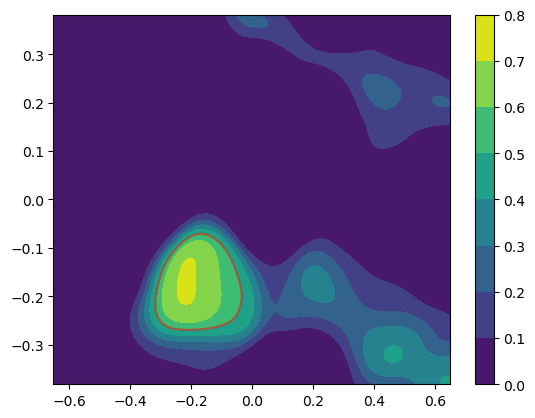

In [103]:
x_bounds = boundary_helper.bounds[0]
z_bounds = boundary_helper.bounds[2]

X, Z = torch.meshgrid(torch.linspace(x_bounds[0], x_bounds[1], 100, device=device), 
                         torch.linspace(z_bounds[0], z_bounds[1], 100, device=device))

pts = torch.vstack([X.flatten(), torch.ones_like(X.flatten())*0.4, Z.flatten()]).T
pts = pts.unsqueeze(0).repeat(2, 1, 1)
slice_points = PointWrapper.create_from_equal_bx(pts)

pts_vals = netp(slice_points.data, slice_points.z_in(z[:1, :]))

plt.contour(X.cpu().detach().numpy(), Z.cpu().detach().numpy(), pts_vals[:, 0].cpu().detach().numpy()[:10000].reshape(100, 100), levels=[0.5], colors='r', alpha=0.5)
plt.contourf(X.cpu().detach().numpy(), Z.cpu().detach().numpy(), pts_vals[:, 0].cpu().detach().numpy()[:10000].reshape(100, 100))


plt.colorbar()

In [89]:
boundary_helper.bounds

tensor([[-0.6506,  0.6506],
        [-1.1000,  1.1000],
        [-0.3816,  0.3816]], device='cuda:0')

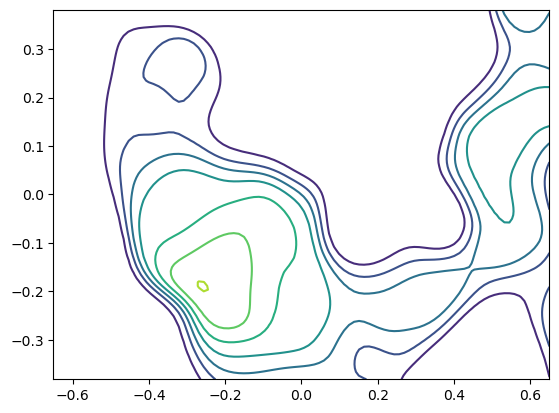

In [38]:
grid._select_w_mask(incl_mask=((p_vals - 0.5).abs() < 5e-3).view(-1))

In [110]:
boundary_helper.surf_pts_uniform_stepsize = 0.1
boundary_helper.surf_pts_uniform_n_iter_reproj = 20

success, p_resampled = boundary_helper.resample(p_surface, z, num_iters=100, debug=True, filter_thr_reproj=1e-2)
success

TypeError: ShapeBoundaryHelper.resample() got an unexpected keyword argument 'plot'

In [33]:
p_resampled.data.shape

torch.Size([287, 3])

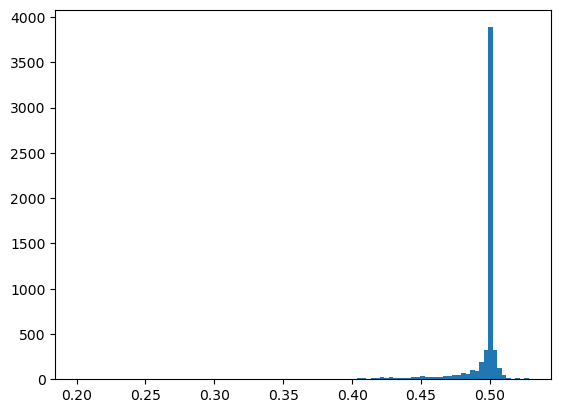

In [42]:
plt.hist(p_vals.squeeze().detach().cpu().numpy(), bins=100)
plt.show()

In [ ]:
boundary_helper.get_grid_starting_pts()

In [65]:
verts, faces = meshes[0]
color = 0xbbbbbb


fig = k3d.plot(height=1000) #, camera_fov=1.0)
n_cols = 2

bounds = cfg['bounds'].cpu().numpy()
shape_grid = 1.5*(bounds[:,1] - bounds[:,0]) ## distance between the shape grid for plotting

for i_shape in range(len(meshes)):
    i_col = (i_shape  % n_cols)
    i_row = (i_shape // n_cols)
    verts, faces = meshes[i_shape]
    group = f'Shape {i_shape}'
    fig += k3d.mesh(verts, faces, group=group, color=color, side='double', wireframe=True,
                    flat_shading=False, opacity=1.0, name=f"Shape_{i_shape}", translation=[0, shape_grid[1]*i_col, shape_grid[2]*i_row])
    fig += k3d.points(p_surface.pts_of_shape(i_shape).cpu().numpy(), point_size=0.003, name=f'pts_{i_shape}', translation=[0, shape_grid[1]*i_col, shape_grid[2]*i_row])
    fig += k3d.points(p_resampled.pts_of_shape(i_shape).cpu().numpy(), point_size=0.003, name=f'pts_{i_shape}', translation=[0, shape_grid[1]*i_col, shape_grid[2]*i_row], color=0xff0000)
    #fig += k3d.points(grid.pts_of_shape(i_shape).cpu().numpy(), point_size=0.003, name=f'pts_{i_shape}', translation=[0, shape_grid[1]*i_col, shape_grid[2]*i_row], color=0xff0000)

# fig += k3d.mesh(verts, faces, color=color, side='double', flat_shading=False, opacity=1.0, name="Shape")

## Debug nearest-neighbor
# knn_edges = torch.stack((
#     torch.arange(knn_indices.shape[0]).repeat(knn_indices.shape[1],1).T, 
#     knn_indices)).flatten(start_dim=1).T.cpu().numpy()
# fig += k3d.lines(points_prev.cpu().numpy(), knn_edges, indices_type='segment', shader="simple", width=0.01, color=0x0000ff)

## Debug density
# fig += k3d.points(points_prev.cpu().numpy(), point_size=0.003, attribute=density_w.detach().cpu().numpy(), name='pts') ## can also plotmean_knn_dists

## Debug directions
# fig += k3d.vectors(points_prev.cpu().numpy(), move.detach().cpu().numpy(), color=0x0000ff, line_width=0.0001, head_size=0.01, name='move')

## Debug resampling
# fig += k3d.points(p_orig.detach().cpu().numpy(), point_size=0.003, color=0x00ff00, name='pts')
# fig += k3d.points(p_resampled.data.detach().cpu().numpy(), point_size=0.003, color=0xff0000, name='resampled')
# fig += k3d.points(p_surface.data.detach().cpu().numpy(), point_size=0.003, color=0x0000ff, name='surface')
# fig += k3d.points(p_reproj.data.detach().cpu().numpy(), point_size=0.003, color=0x0000ff, name='reproj')
# fig += k3d.vectors(p_resampled.detach().cpu().numpy(), (p_resampled.data - p_reproj.data).detach().cpu().numpy(), color=0x0000ff, line_width=0.0001, head_size=0.01, name='move')

## Plot trajectories
def trajectories_to_verts_inds(trajectories):
    vertices = trajectories.reshape(-1,3).cpu().numpy()
    # K steps, P points, 3 coordinates
    K, P, _ = trajectories.shape
    start_indices = np.arange((K - 1) * P)
    end_indices = start_indices + P
    # Stack them to form the pairs of indices for the lines
    indices = np.vstack([start_indices, end_indices]).T
    return vertices, indices
## Filter trajectories
# converged_mask = x_path_over_iters[-1,:,0].isnan()
# trajs = x_path_over_iters #x_path_over_iters[:,~converged_mask][:,::1]
# fig += k3d.lines(*trajectories_to_verts_inds(trajs), indices_type='segment', shader="simple", width=0.01, color=0x0000ff)
# fig += k3d.points(p_in.data.detach().cpu().numpy(), point_size=0.003, color=0x00ff00, name='pts')
# fig += k3d.points(x_path_over_iters[0].cpu().numpy(), point_size=0.003, color=0xff0000, name='pts_init')


## Bounds
# from k3d import platonic
# x_min, x_max, y_min, y_max, z_min, z_max = boundary_helper.bounds.flatten().cpu().numpy()
# cube = platonic.Cube()
# cube.vertices = np.array([
#     [x_max, y_max, z_max],
#     [x_max, y_max, z_min],
#     [x_max, y_min, z_max],
#     [x_max, y_min, z_min],
#     [x_min, y_max, z_max],
#     [x_min, y_max, z_min],
#     [x_min, y_min, z_max],
#     [x_min, y_min, z_min],
#     ])
# fig += k3d.mesh(cube.vertices, cube.indices, side="double", opacity=.5, color=0xff0000)

fig.display()

Output()